# Equivariance to Temporal Dynamics in Neural Scene Representations

This notebook contains examples of how to load a trained Temporal Equivariant Neural Renderer and use it to infer scene representations from a single image, as well as rendering novel views of the scene, and interpolations between temporal steps.

Setup: This implementation should run out of the box if the requirements.txt packages are installed.

In [1]:
import imageio
import torch
import IPython.display

from torchvision.transforms import ToTensor
from misc.temporal_viz import *
from models.neural_renderer import load_model

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/Users/SNPfabian/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/SNPfabian/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: <F509E3F0-6853-385F-998A-98FA3DF2CAFF> /Users/SNPfabian/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <22270481-544D-33A2-9FD1-270293676910> /Users/SNPfabian/opt/anaconda3/lib/python3.9/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


## Load trained model
The trained model can be found in folder 'trained_models'.

In [2]:
# Load temporal rendering model
model = load_model('trained-models/best_model.pt').to(device)

The following image provides an overview of the model architecture. This may help in understanding the different aspects of the code below. The model consists of an inverse rendered, which renders an input image into a scene represenation per temporal step. We can then choose one of the temporal scene representations to use to shift in temporal dimension; time. Afterwards, if desired, rotation can be applied before feeding the scene representation back into the forward renderer to create the final rendered image.

<p align="center">
  <img width=900px src="imgs/model_architecture.png" />
</p>

## Load image
We first load our input image. Example images from the test set can be found in the folder 'imgs/example-data/'. These images are completely new to the model and have never been seen during training or validation. The default test image ```01806.png``` has the following parameters:

```azimuth```: 310.20476364878255 \
```elevation```: 2.8318435497339607 \
```temporal```: 9

/var/folders/lv/sg29c_8n4fqgby7fj1djfc9h0000gq/T/ipykernel_93369/798434753.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('imgs/example-data/01806.png')


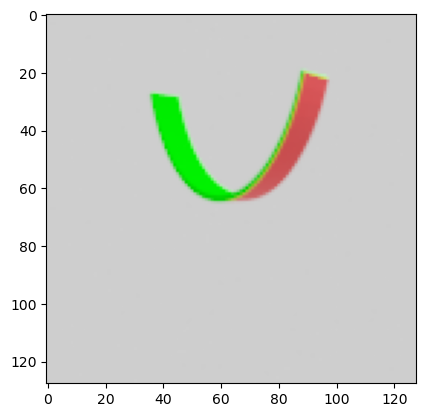

In [3]:
# You can try any image from the example-data folder.
img = imageio.imread('imgs/example-data/01806.png')

# Visualize input image
plt.imshow(img)

## Infer and render scene representation
The input image is rendered into a 4D scene representation, with a 3D scene for every temporal dimension.

In [4]:
# Convert image to tensor and add batch dimension
img_source = ToTensor()(img)
img_source = img_source.unsqueeze(0).to(device)

# Infer scene representation
scene = model.inverse_render(img_source)
scenes = scene.reshape(1, model.temporal_channels, int(scene.shape[1] / model.temporal_channels), *scene.shape[2:])

# Print shape of scenes in all temporal dims
print("Scenes shape: {}".format(scenes.shape))
print("Number of temporal channels: {}".format(model.temporal_channels))

Scenes shape: torch.Size([1, 20, 3, 32, 32, 32])
Number of temporal channels: 20


## Generate novel views for different timesteps
By selecting a target timestep, we can now render views from the 4D scene representation. There are 20 timesteps present in the latent scene representation. As we use the index to select the temporal dimension, you can choose from [0,19]. As we trained with temporal differences, t=0 means that the object moves 10 timesteps back in time, t=19 means that the object moves 10 timestep forward in time. By selecting t=10, we simply reconstruct our input image from our latent space. 

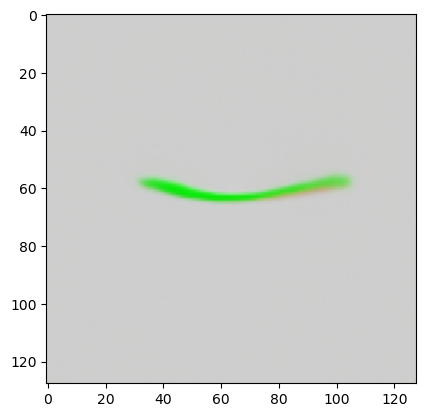

In [5]:
# Try any timestep that you would like to see.
target_timestep = 3

# Apply spherical mask to scene
scene = model.spherical_mask(scenes[0, target_timestep, ...]).unsqueeze(0)

# We can render the scene representation without rotating it
rendered = model.render(scene)
plot_img_tensor(rendered.detach())

## Generate novel views for all timesteps
This operation can be performed on all timesteps to view the model performance. It is visible that t=0 is not rendering correctly. This is due to training, as this temporal difference for t=0 was not present in the training data.

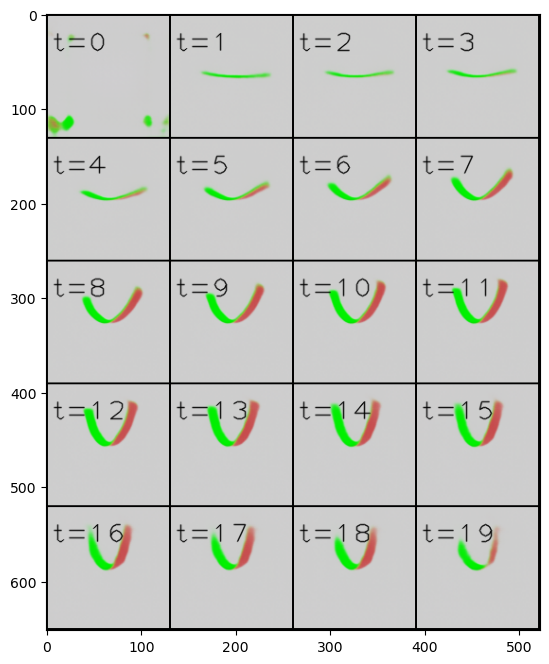

In [6]:
labels = [f"t={t}" for t in range(model.temporal_channels)]
plot_img_tensor(model.render(model.spherical_mask(scenes.squeeze()).squeeze()).detach(), labels, figsize=(12,8))

## Interpolation for a single view
We can also interpolate between views, by merging two neighbouring scenes.

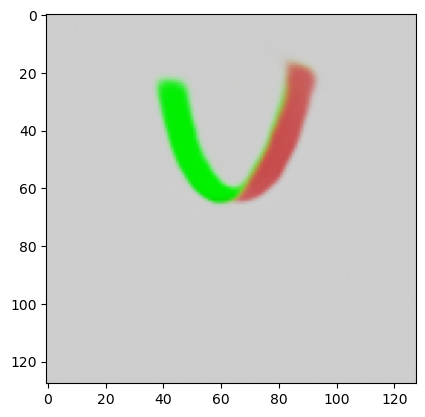

In [7]:
# We can use interpolation to sample within timesteps (use floats to do so)
target_timestep = 13.1
plot_img_tensor(render_interpolated(model, scenes, target_timestep).detach(), labels)      

## Interpolation linspace between two timesteps
To show the smoothness of the interpolation, a linspace of rendered timestep images can be constructed.

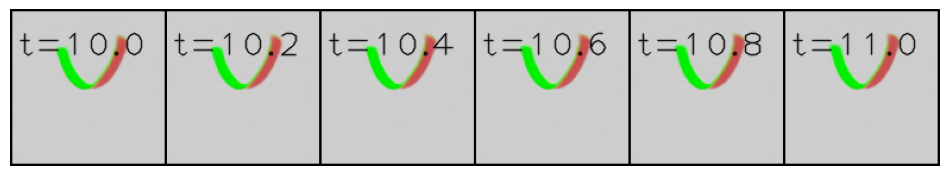

In [8]:
# Experiment 1: Interpolate every half value in between timesteps
begin_val = 10
end_val = 11
steps = 6

time_steps = np.linspace(begin_val, end_val, steps)
renders = torch.cat([render_interpolated(model, scenes, t).detach() for t in time_steps]).detach()
labels = [f"t={t}" for t in time_steps]
plot_img_tensor(renders, labels, save_file='imgs/interpolated_between_values.png', nrow=steps, figsize=(12,8))      

## Interpolation between all timesteps
We can now interpolate between all timesteps to see if the model produces equal interpretable represenations per timestep. Again, we can see that the zero dimension is not trained, and therefore, any interpolations lower than 1. will result in a distorted image. 

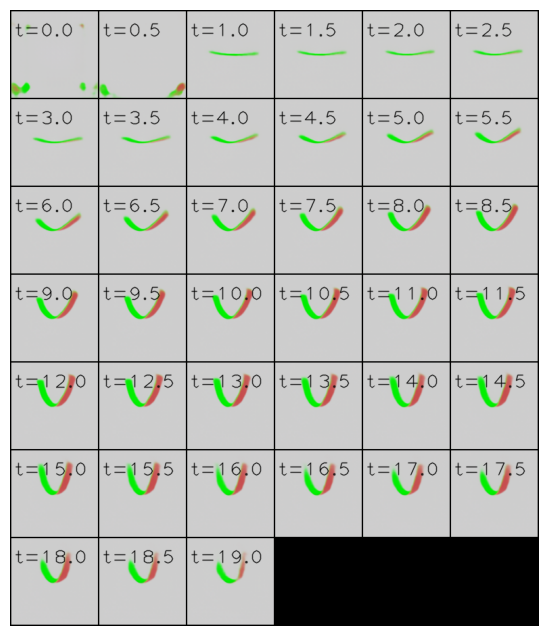

In [9]:
# Experiment 2: Interpolate every half value in between timesteps
begin_val = 0.0
end_val = 19.0
steps = 39

time_steps = np.linspace(begin_val, end_val, steps)
renders = torch.cat([render_interpolated(model, scenes, t).detach() for t in time_steps]).detach()
labels = [f"t={t}" for t in time_steps]

plot_img_tensor(renders, labels, save_file='imgs/interpolated_halves.png', nrow=6, figsize=(12,8))      

## Visualizing the 3D scene representation
The following cells will visualise the 3D scene representation over all timesteps. As the scene is encoded in a (3,32,32,32) Tensor, we can nicely visualize 32 slices in color 32 x (3,32,32). It is visible that the model seems to encode the temporal dimension in color. We can also see that neighbouring scenes have similar structre, both in terms of color and shape per slice, therefore clean interpolation is possible. It will be shown in the next cell once completed. 

In [10]:
%%capture

# Create frames of gif and save in folder 'scene_rep/'
for time_step in range(model.temporal_channels):
    generate_scene_rep_images(scenes, time_step, sigmoid=True)

# Create gif from saved frames (this gif will display in the next cell once it has been saved)
make_gif_scene_rep()

In [17]:
IPython.display.Image(url='imgs/scene_renders.gif', width=350) 

## Generate novel views for different angles
We can now add the rotational aspect of the model. First with a rotation matrix on one image, then with azimuth/elevation angles.

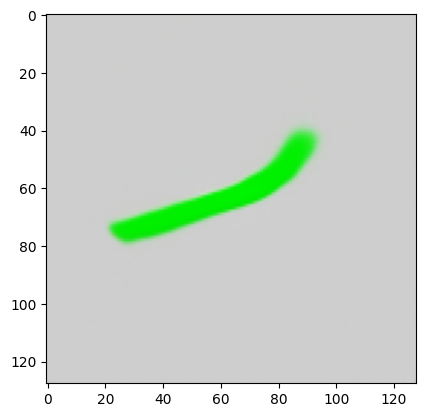

In [12]:
# Initialize a rotation matrix
rotation_matrix = torch.Tensor(
   [[[ 0.4198, -0.3450, -0.8395],
     [-0.2159,  0.8605, -0.4615],
     [ 0.8816,  0.3749,  0.2867]]]
).to(device)

# Rotate scene by applying rotation matrix to 3D representation
rotated_scene = model.rotate(scene, rotation_matrix)

# Render rotated scene
rendered = model.render(rotated_scene)
plot_img_tensor(rendered.detach())

### Azimuth / Elevation
As a rotation matrix can feel a little abstract, we can also reason in terms of camera azimuth and elevation. The initial coordinate at which the source image is observed is given by the following azimuth and elevation. Note that these are not necessary to generate novel views (as shown above), we just use them for convenience to generate rotation matrices. The image below shows the azimuth/elevation coordinate system.

<p align="center">
  <img width=300px src="imgs/azimuth_elevation.gif" />
</p>

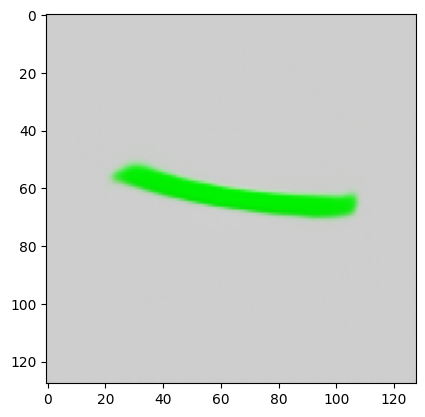

In [13]:
# Coordinates of default test image
azimuth_source = torch.Tensor([310.20476364878255]).to(device)
elevation_source = torch.Tensor([2.8318435497339607]).to(device)

# You can set these to any value you like!

# Positive (negative) values correspond to moving camera to the right (left)
azimuth_shift = torch.Tensor([160.]).to(device)  

# Positive (negative) values correspond to moving camera up (down)
elevation_shift = torch.Tensor([20.]).to(device)

azimuth_target = azimuth_source + azimuth_shift
elevation_target = elevation_source + elevation_shift

# Rotate scene to match target camera angle
rotated_scene = model.rotate_source_to_target(scene, azimuth_source, elevation_source, 
                                              azimuth_target, elevation_target)

# Render rotated scene
rendered = model.render(rotated_scene)
plot_img_tensor(rendered.detach())

## Generate novel view for multiple angels at once
Combining everything! We can now combine both the temporal selection and the roation. Use the cell underneath to visualise the object for a selected temporal step for different angles.

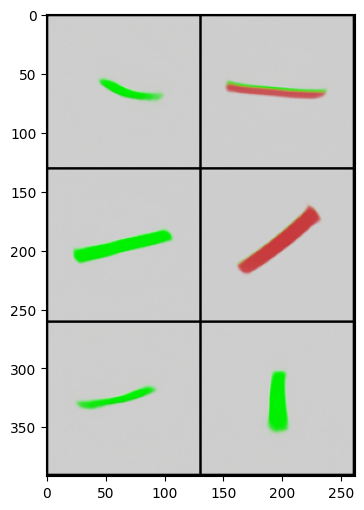

In [14]:
# Select target time step
target_timestep = 2

# We can also generate several novel views of the same object
azimuth_shifts = torch.Tensor([20., -50., 120., 180., -90., 50.]).to(device)
elevation_shifts = torch.Tensor([10., -30., 40., -70., 10., 30.]).to(device)

# This function expects a single image as input, so remove batch dimension
views = generate_novel_views(model, img_source, azimuth_source, elevation_source,
                             azimuth_shifts, elevation_shifts, target_timestep)

# Plot views in matrix
labels = ["" for _ in range(len(azimuth_shifts))]
plot_img_tensor(views.detach(), labels=labels, nrow=2, figsize=(12,6))

## Generate novel view animation
This leads to our final animation which includes everything: the object over different timesteps for different angles. This might take a while to load. It will be shown in the next cell once completed. (Unfortunately, It will only run one)

In [15]:
# Number of frames per timestep
num_frames = 10

# Desired timesteps to include
time_steps = np.arange(0, model.temporal_channels)

# Desired angles
azimuth_shifts = full_rotation_angle_sequence(num_frames).to(device)
elevation_shifts = sine_squared_angle_sequence(num_frames, -10., 20.).to(device)

# Generate views
views = batch_generate_novel_views(model, img_source, azimuth_source,
                                   elevation_source, azimuth_shifts,
                                   elevation_shifts, time_steps)

# Save generated gif (this gif will display in the next cell once it has been saved)
save_img_sequence_as_gif(views, 'imgs/novel_views_example.gif')

In [16]:
IPython.display.Image(url='imgs/novel_views_example.gif', width=350) 